In [1]:
using Revise

In [2]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Plots
;

In [20]:
const λ = 1
const Γ = 2π
const m = 1
const k = 2π / λ
;

In [21]:
H_operator = :(
    B * Rotation +
    T * L +
    B_z * (Zeeman_L0 + 0 * Zeeman_L1)
)
parameters = @params begin
    B = 0.1
    T = 2.5
    B_z = 0.0
end

# Create basis states
QN_bounds = (L = 0, N = 0:1)
ground_states = enumerate_states(AngularMomentumState_Labelled, QN_bounds)
QN_bounds = (L = 1, N = 1)
excited_states = enumerate_states(AngularMomentumState_Labelled, QN_bounds)

# Create Hamiltonian
basis = [ground_states; excited_states]
H = Hamiltonian(basis=basis, operator=H_operator, parameters=parameters)

#
TDM_x1(state, state′) = sum(arg * TDM(state, state′, q-2) + conj(arg * TDM(state′, state, q-2)) for (q,arg) ∈ enumerate(rotate_pol(σ⁺, +x̂)))
TDM_x2(state, state′) = sum(arg * TDM(state, state′, q-2) + conj(arg * TDM(state′, state, q-2)) for (q,arg) ∈ enumerate(rotate_pol(σ⁺, -x̂)))
H = add_to_H(H, :s, TDM_x1 + TDM_x2)
H.parameters.s = 1.0

evaluate!(H)
QuantumStates.solve!(H)
;

In [5]:
update_basis_tdms!(H)
update_tdms!(H)
d = H.tdms

d[1:4, 5:end, :] ./= sqrt(sum(d[1:4, 5:end, 1].^2))
d[5:end, 1:4, :] ./= sqrt(sum(d[5:end, 1:4, 1].^2))
;

In [6]:
# Laser parameters
Δ = +2Γ
s = 1.0

# Frequency of the lasers (in angular frequency units)
ω1 = 2π * (energy(H.states[end]) - energy(H.states[1])) + Δ
ω2 = 2π * (energy(H.states[end]) - energy(H.states[4])) - Δ

ϵ_(ϵ1) = t -> ϵ1

k̂ = +x̂; ϵ1 = ϵ_( -im .* rotate_pol(σ⁺, k̂)); laser1 = Field(k̂, ϵ1, ω1, s)
k̂ = -x̂; ϵ2 = ϵ_( -im .* rotate_pol(σ⁺, k̂)); laser2 = Field(k̂, ϵ2, ω1, s)
k̂ = +ŷ; ϵ3 = ϵ_( -rotate_pol(σ⁺, k̂)); laser3 = Field(k̂, ϵ3, ω1, s)
k̂ = -ŷ; ϵ4 = ϵ_( -rotate_pol(σ⁺, k̂)); laser4 = Field(k̂, ϵ4, ω1, s)
k̂ = +ẑ; ϵ5 = ϵ_( rotate_pol(σ⁺, k̂)); laser5 = Field(k̂, ϵ5, ω1, s)
k̂ = -ẑ; ϵ6 = ϵ_( rotate_pol(σ⁺, k̂)); laser6 = Field(k̂, ϵ6, ω1, s)

k̂ = +x̂; ϵ7 = ϵ_( -im .* rotate_pol(σ⁻, k̂)); laser7 = Field(k̂, ϵ7, ω2, s)
k̂ = -x̂; ϵ8 = ϵ_( -im .* rotate_pol(σ⁻, k̂)); laser8 = Field(k̂, ϵ8, ω2, s)
k̂ = +ŷ; ϵ9 = ϵ_( -rotate_pol(σ⁻, k̂)); laser9 = Field(k̂, ϵ9, ω2, s)
k̂ = -ŷ; ϵ10 = ϵ_( -rotate_pol(σ⁻, k̂)); laser10 = Field(k̂, ϵ10, ω2, s)
k̂ = +ẑ; ϵ11 = ϵ_( rotate_pol(σ⁻, k̂)); laser11 = Field(k̂, ϵ11, ω2, s)
k̂ = -ẑ; ϵ12 = ϵ_( rotate_pol(σ⁻, k̂)); laser12 = Field(k̂, ϵ12, ω2, s)

lasers = [laser1, laser2, laser3, laser4, laser5, laser6]#, laser7, laser8, laser9, laser10, laser11, laser12]
;

In [7]:
# `Particle` type defines the starting position `r0` and velocity `v` used for the simulation
particle = Particle()

# Define the density matrix `ρ0` at t = 0
ρ0 = zeros(ComplexF64, length(H.states), length(H.states))
ρ0[2,2] = 1.0

# `freq_res` designates the resolution used for the frequencies and velocity used in the simulation
freq_res = 1e-1

p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res, nothing)

# Define the end time `t_end` of the simulation
t_end = 30p.period
tspan = (0., t_end)

prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p)
;

In [8]:
callback = PeriodicCallback(reset_force!, prob.p.period)

prob.p.r0 = (0., 0., 0.8) .* 2π
prob.p.v = (0., 0., 0.0)
@time sol = DifferentialEquations.solve(prob, alg=DP5(), reltol=1e-3, callback=callback)
prob.p.force_last_period .* 1e3

  9.652924 seconds (13.64 M allocations: 883.785 MiB, 5.19% gc time, 99.75% compilation time)


3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
 1.4714189015398365e-19
 2.6559992844727824e-20
 0.0003201649274432385

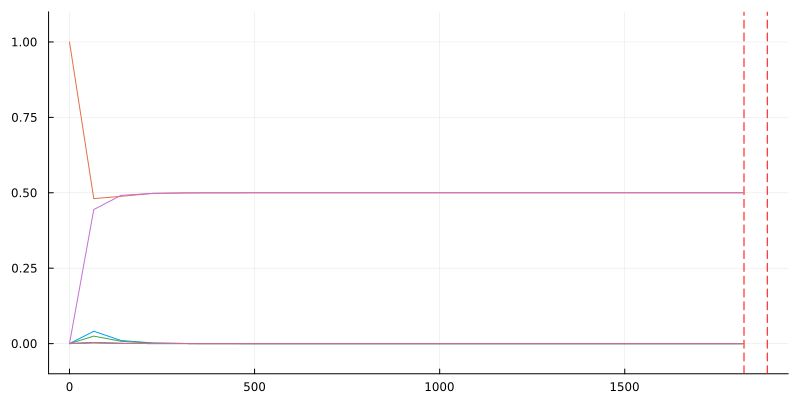

In [9]:
using Plots
plot_us = sol.u[1:100:end]
plot_ts = sol.t[1:100:end]

n_states = size(p.ρ_soa, 1)
plot(size=(800, 400), ylim=(-0.1, 1.1), legend=nothing)
for i in 1:n_states
    state_idx = n_states*(i-1) + i
    plot!(plot_ts, [real(u[state_idx]) for u in plot_us])
end
plot!()
offset = 0
vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

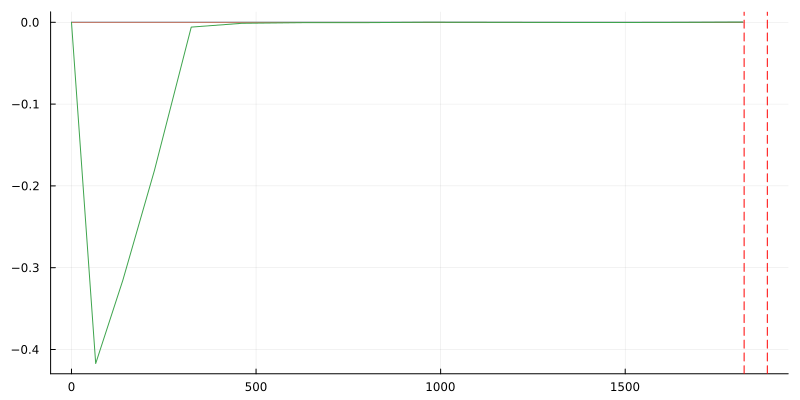

In [10]:
plot(size=(800, 400), legend=nothing)
plot!(plot_ts, 1e3 .* [real(u[end-2]) for u in plot_us] ./ prob.p.period)
plot!(plot_ts, 1e3 .* [real(u[end-1]) for u in plot_us] ./ prob.p.period)
plot!(plot_ts, 1e3 .* [real(u[end]) for u in plot_us] ./ prob.p.period)
plot!()
offset = 0
vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

In [11]:
# E_test(x,y,z) = √2 .* [sin(k * z) - cos(k * y), sin(k * x) - cos(k * z), sin(k * y) - cos(k * x)] .* cos(p.fields.ω[1] * t_end)
E_test(x,y,z) = √2 .* [sin(z) - cos(y), sin(x) - cos(z), sin(y) - cos(x)] .* cos(p.fields.ω[1] * t_end)
# E_test(x,y,z) = √2 .* [sin(z), - cos(z), 0] .* cos(p.fields.ω[1] * t_end)

E_test (generic function with 1 method)

In [12]:
using Distributions
uniform_dist = Uniform(0, 2π)
function sample_direction(r=1.0)
    θ = 2π * rand()
    z = rand() * 2 - 1
    return (r * sqrt(1 - z^2) * cos(θ), r * sqrt(1 - z^2) * sin(θ), r * z)
end
;

## Laser cooling force versus velocity

In [20]:
function prob_func!(prob, scan_params, i)
    p = prob.p
    # Update velocity and position
    p.v .= (scan_params[i].v, 0.0, 0.1)
    p.v .= round_vel(p.v, p.freq_res)
    p.r0 .= scan_params[i].r
    return prob
end
function output_func(p, sol)
    f = p.force_last_period
    return (f[1], 0, 0)
end
;

In [21]:
using RectiGrids
di = 7
rs = vcat([(n1*λ/(di+1), n2*λ/(di+1), n3*λ/(di+1)) .* 2π for n1 ∈ 0:di, n2 ∈ 0:di, n3 ∈ 0:di]...)
vs = 0:0.1:7.0

scan_values = (r = rs, v = vs)
scan_values_grid = RectiGrids.grid(scan_values)
;

In [22]:
freq_res = 1e-1
p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res)

t_end = 5p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-5, save_on=false)
;

In [23]:
@time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func!, output_func);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:51m


 51.214365 seconds (8.85 M allocations: 1.605 GiB, 0.65% gc time, 59.94% compilation time)


In [24]:
averaged_forces = []
@time for (i,v) ∈ enumerate(vs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.v == v]
    push!(averaged_forces, mean([f[1] for f in forces[idxs]]))
end

  0.178900 seconds (183.59 k allocations: 13.820 MiB, 92.20% compilation time)


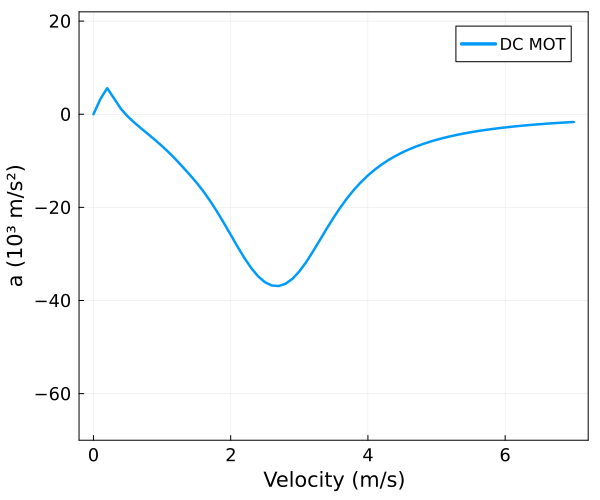

In [25]:
plot(vs, 1e3 .* averaged_forces,
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    ylim=(-70,22),
    label="DC MOT",
    size=(600,500)
    )

In [26]:
function prob_func!(prob, scan_params, i)
    p = prob.p
    # Update velocity and position
    p.v .= sample_direction(scan_params.v[i])
    p.v .= round_vel(p.v, p.freq_res)
    p.r0 .= rand(uniform_dist, 3)
    prob
end
function param_func(prob, scan_params, i)
    return scan_params.v[i]
end
function output_func(p, sol)
    f = p.force_last_period
    return (f ⋅ p.v / norm(p.v), 0, 0)
end
;

In [27]:
freq_res = 1e-2
p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res)

t_end = 10p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-4, save_on=false)

n_samples = 100
vs = repeat(collect(0:0.01:1.0), n_samples)

using RectiGrids
scan_values = (v = vs,)
scan_values_grid = RectiGrids.grid(scan_values)
;

In [28]:
@time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func!, output_func);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


 34.660219 seconds (1.62 M allocations: 398.761 MiB, 0.20% gc time, 5.88% compilation time)


In [29]:
averaged_forces = []
@time for (i,v) ∈ enumerate(vs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.v == v]
    push!(averaged_forces, mean([f[1] for f in forces[idxs]]))
end

  0.283338 seconds (368.51 k allocations: 66.190 MiB, 11.70% gc time, 41.73% compilation time)


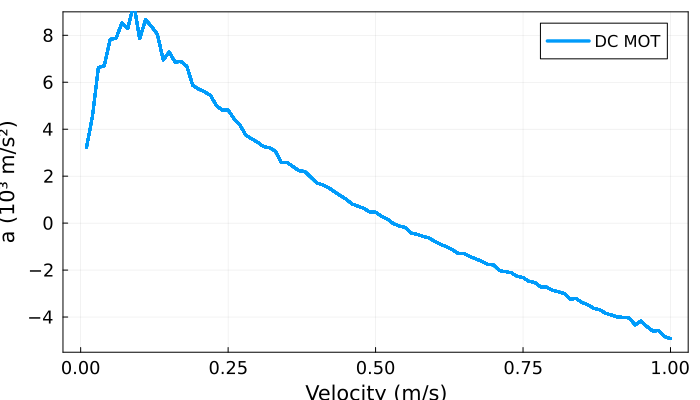

In [30]:
plot(vs, 1e3 .* averaged_forces,
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    label="DC MOT",
    ylim=(-5.5,9),
    size=(700,400)
    )

## Laser cooling force versus magnetic field

In [13]:
function prob_func!(prob, scan_params, i)
    p = prob.p
    
    # Update velocity and position
    p.particle.v .= scan_params[i].v
    p.particle.r0 .= scan_params[i].r
    
    # Update magnetic field
    H = p.extra_p.H
    H.parameters.B_z = scan_params[i].B
    evaluate!(H)
    QuantumStates.solve!(H)
    
    # Update transition dipole moments
    update_basis_tdms!(H)
    update_tdms!(H)
    new_d = H.tdms
    
    new_p = obe(p.ρ0, p.particle, H.states, p.extra_p.lasers, new_d, nothing, true, true, p.λ, p.Γ, p.freq_res, p.extra_p)
    
    return remake(prob, p=new_p)
end
function output_func(p, sol)
    f = p.force_last_period
    return f
end
;

In [14]:
using RectiGrids

freq_res = 1e-1
extra_p = (H=H, lasers=lasers)
p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res, extra_p)

t_end = 10p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-3, save_on=false)

Bs = 0:0.1:3.0
di = 7
rs = vcat([(n1/(di+1), n2/(di+1), n3/(di+1)) .* 2π for n1 ∈ 0:di, n2 ∈ 0:di, n3 ∈ 0:di]...)
vs = [sample_direction(0.0) for _ in 1:1]

scan_values = (B = Bs, r = rs, v = vs)
scan_values_grid = RectiGrids.grid(scan_values)
;

In [15]:
@time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func!, output_func);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:21m


 21.447225 seconds (16.02 M allocations: 1.814 GiB, 2.28% gc time, 345.79% compilation time)


In [16]:
averaged_forces = []
@time for (i,B) ∈ enumerate(Bs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.B == B]
    push!(averaged_forces, mean([f[3] for f in forces[idxs]]))
end

  0.212193 seconds (212.08 k allocations: 14.762 MiB, 94.97% compilation time)


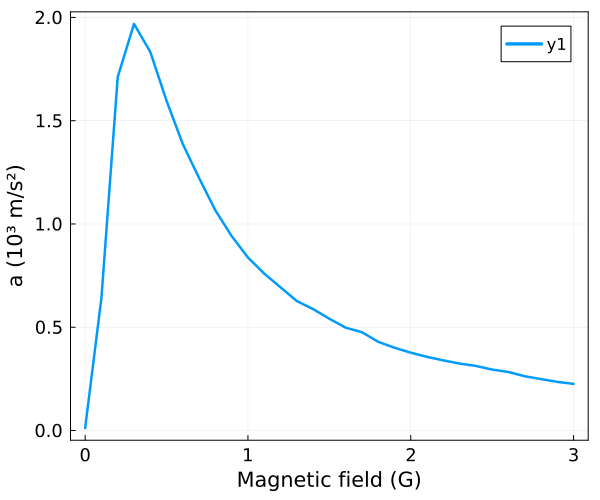

In [17]:
plot(Bs, 1e3 .* averaged_forces,
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    # ylim=(-3,23),
    size=(600,500)
    )

In [18]:
averaged_populations = []
@time for (i,B) ∈ enumerate(Bs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.B == B]
    push!(averaged_populations, mean([p for p in populations[idxs,:]], dims=1))
end

  0.171935 seconds (99.68 k allocations: 8.454 MiB, 12.82% gc time, 97.68% compilation time)


In [19]:
averaged_populations[10]'

7×1 adjoint(::Matrix{Float64}) with eltype Float64:
 0.1161168226904856
 0.18991592382927414
 0.2676248415639064
 0.38972985818261435
 0.011709602484070368
 0.014847136363841558
 0.01005581488580835